## Image Caption Generator

# Data processing

In [0]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input

import numpy as np
import h5py
import string
import pickle

from os import listdir
from os.path import join, isdir, isfile, exists

Using TensorFlow backend.


In [0]:
import os


os.environ['KAGGLE_USERNAME'] = 'ericsamikwa'
os.environ['KAGGLE_KEY'] = 'ab323a3683cdd4349d56e2fbd9dda7b1'

#import kaggle 
#kaggle.api.authenticate()
#kaggle.api.dataset_download_files
# Takes ~70 secs
!kaggle datasets download -d ming666/flicker8k-dataset
!unzip -q flicker8k-dataset.zip

# Discard extra directories
! rm -rf flickr8k_dataset/
! rm -rf flickr8k_text/
! rm -rf sample_data/

# Create Train and Valid directories
os.mkdir('Flickr8k_Dataset/Train_Images')
os.replace('Flickr8k_Dataset/Flicker8k_Dataset', 'Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train')



100% 2.07G/2.08G [00:14<00:00, 33.7MB/s]
100% 2.08G/2.08G [00:14<00:00, 154MB/s] 


In [0]:
import shutil

#shutil.move("/content/Flickr8k_Dataset/Flicker8k_Dataset_Train/*", "/content/Flickr8k_Dataset/")

In [0]:
root_path = '/content/'
meta_info = {
    'image_dir': '/content/Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train/',
    'train_list': '/content/Flickr8k_text/Flickr_8k.trainImages.txt',
    'dev_list': '/content/Flickr8k_text/Flickr_8k.devImages.txt',
    'test_list': '/content/Flickr8k_text/Flickr_8k.testImages.txt',
    'text_dir': '/content/Flickr8k_text'
}

print(listdir(meta_info['image_dir'])[:5])

['3351667632_00f586a30c.jpg', '2896668718_0c3cff910f.jpg', '3051341320_1d0166e775.jpg', '2271667421_7b21fc23b8.jpg', '3138504165_c7ae396294.jpg']


## Image preprocessing

In [0]:
# feature extraction CNN model

from keras.applications.vgg19 import VGG19, preprocess_input

def model_selection(model_name):
    
    if model_name == 'VGG19':
         
        model = VGG19() # 4096
    
    return model

In [0]:
model = 'VGG19'
main_model = model_selection(model)

cnn_model = Model(inputs=main_model.inputs, outputs=main_model.layers[-2].output)
cnn_model.summary()





574717952/574710816 [==============================] - 6s 0us/step






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________

### Image to feature

In [0]:

# testing with validation set


validation_features = {}
val_h5 = root_path+'validation_features.h5'
with h5py.File(val_h5, 'w') as h5f:
    with open(meta_info['dev_list']) as f:
        c = 0 # count
        contents = f.read()
        for line in contents.split('\n'):
            if line == '': # last line or error line
                print(c)
                continue
            if c % 100 == 0:
                print(c)
           
            target_size = (224, 224)
                
            img_path = line
            img = load_img(meta_info['image_dir'] + img_path, target_size=target_size)
            img = img_to_array(img)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            feature = cnn_model.predict(img)
            h5f.create_dataset(img_path.split('.')[0], data=feature)
            c += 1

0
100
200
300
400
500
600
700
800
900
1000


In [0]:
# feature test
with h5py.File('validation_features.h5', 'r') as h5f:
    print(h5f['2090545563_a4e66ec76b'][:])

[[0.        0.        1.0180278 ... 0.        0.        0.       ]]
(1, 4096)


In [0]:
#training features

training_features = {}
train_h5 = 'training_features.h5'
with h5py.File(train_h5, 'w') as h5f:
    with open(meta_info['train_list']) as f:
        c = 0 # count
        contents = f.read()
        for line in contents.split('\n'):
            if line == '': # last line or error line
                print(c)
                continue
            if c % 1000 == 0:
                print(c)

            
            target_size = (224, 224)
                
            img_path = line
            img = load_img(meta_info['image_dir'] + img_path, target_size=target_size)
            img = img_to_array(img)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            feature = cnn_model.predict(img)
            h5f.create_dataset(img_path.split('.')[0], data=feature)
            c += 1

0
1000
2000
3000
3222


In [0]:
test_features = {}
test_h5 = 'test_features.h5'
with h5py.File(test_h5, 'w') as h5f:
    with open(meta_info['test_list']) as f:
        c = 0 # count
        contents = f.read()
        for line in contents.split('\n'):
            if line == '': # last line or error line
                print(c)
                continue
            if c % 100 == 0:
                print(c)
           
            target_size = (224, 224)
                
            img_path = line
            img = load_img(meta_info['image_dir'] + img_path, target_size=target_size)
            img = img_to_array(img)
            img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
            img = preprocess_input(img)
            feature = cnn_model.predict(img)
            h5f.create_dataset(img_path.split('.')[0], data=feature)
            c += 1

0
100
200
300
400
500
600
700
800
900
1000


## Text preprocessing

In [0]:
# full captions to dictionary
# The dictionary has full dataset and numbers are eliminated from all captions.


captions = dict()
words = set()

with open(join(meta_info['text_dir'], 'Flickr8k.token.txt')) as f:
    contents = f.read()
    n_captions = 0
    for line in contents.split('\n'):
        if line == '':
            print(n_captions)
            continue
        if n_captions % 10000 == 0:
            print(n_captions)
        
        file, caption = line.split('\t')
        
        table = str.maketrans('', '', string.punctuation)
        
        caption2 = []
        for word in caption.split():
            # remove number
            if word.isalpha():
                caption2.append(word.translate(table))
        caption = ' '.join(caption2)
        
        img_id = file.split('.')[0]
        
        if img_id in captions.keys():
            captions[img_id].append(caption)
        else:
            captions[img_id] = [caption]
        n_captions += 1

        [words.add(word) for word in caption.split()]
        
print('number of images: %d' % len(captions))
print('number of catpions: %d' % n_captions)
print('number of words: %d' % len(words))

0
10000
20000
30000
40000
40460
number of images: 8092
number of catpions: 40460
number of words: 9068


In [0]:
# Only dev captions are taken from the full captions set.
# This captions have sign of start and end for sequence(sssss and eeeee)


val_captions = dict()
val_words = set()

with open(join(meta_info['text_dir'], 'Flickr_8k.devImages.txt')) as f:
    contents = f.read()
    n_val_captions = 0
    for line in contents.split('\n'):
        if line == '':
            print(n_val_captions)
            continue
        if n_val_captions % 10000 == 0:
            print(n_val_captions)
        
        file = line.split('.')[0]
        
        for caption in captions[file]:
            # start sign: sssss
            # end sign: eeeee
            caption = 'sssss ' + caption + ' eeeee'
            caption = caption.replace('\n', '')
            
            if file in val_captions.keys():
                val_captions[file].append(caption)
            else:
                val_captions[file] = [caption]
            n_val_captions += 1
            
            [val_words.add(word) for word in caption.split()]

print('number of catpions: %d' % len(val_captions))
print('number of catpions: %d' % n_val_captions)
print('number of words: %d' % len(val_words))

0
5000
number of catpions: 1000
number of catpions: 5000
number of words: 3409


In [0]:
# Training set must count the maximum number of words in single sentence.


train_captions = dict()
train_words = set()

Max_len_sen = 0 # max length in single sentence

with open(join(meta_info['text_dir'], 'Flickr_8k.trainImages.txt')) as f:
    contents = f.read()
    n_train_captions = 0
    for line in contents.split('\n'):
        if line == '':
            print(n_train_captions)
            continue
        if n_train_captions % 10000 == 0:
            print(n_train_captions)
        
        file = line.split('.')[0]
        
        for caption in captions[file]:
            caption = 'sssss ' + caption + ' eeeee'
            caption = caption.replace('\n', '')
            
            if file in train_captions.keys():
                train_captions[file].append(caption)
            else:
                train_captions[file] = [caption]
            n_train_captions += 1
            
            t = caption.split()
            if len(t) > Max_len_sen:
                Max_len_sen = len(t)
            [train_words.add(word) for word in t]

# n_vocabs = len(train_words) # all word, based str.split()

print('number of catpions: %d' % len(train_captions))
print('number of catpions: %d' % n_train_captions)
print('number of words: %d' % len(train_words))

# print('vocabulary size: %d' % n_vocabs)
print('max number of words in single sentence: %d' % Max_len_sen)

0
10000
16110
number of catpions: 3222
number of catpions: 16110
number of words: 5844
max number of words in single sentence: 36


In [0]:
test_captions = dict()
test_words = set()

with open(join(meta_info['text_dir'], 'Flickr_8k.testImages.txt')) as f:
    contents = f.read()
    n_test_captions = 0
    for line in contents.split('\n'):
        if line == '':
            print(n_test_captions)
            continue
        if n_test_captions % 10000 == 0:
            print(n_test_captions)
        
        file = line.split('.')[0]
        
        for caption in captions[file]:
            caption = 'sssss ' + caption + ' eeeee'
            caption = caption.replace('\n', '')
            
            if file in test_captions.keys():
                test_captions[file].append(caption)
            else:
                test_captions[file] = [caption]
            n_test_captions += 1
            
            [test_words.add(word) for word in caption.split()]

print('number of catpions: %d' % len(test_captions))
print('number of catpions: %d' % n_test_captions)
print('number of words: %d' % len(test_words))

0
5000
number of catpions: 1000
number of catpions: 5000
number of words: 3266


In [0]:
# Making tokenizer, only use train captions.

def make_tokenizer(captions):
    texts = []
    for _, caption_list in captions.items():
        for caption in caption_list:
            texts.append(caption)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer

In [0]:
tokenizer = make_tokenizer(train_captions)
n_vocabs = len(tokenizer.word_index) + 1 # because index 0, plus 1
print('number of vocabulary: %d' % n_vocabs)
#print(tokenizer.word_index)

number of vocabulary: 5484


In [0]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
# print(len(tokenizer.word_index))

In [0]:
import h5py

# Make sequence, Make next word 
# If single sentence consisting of N words, N + 1(because end sign) sequences are created.

train_sequences = list()
train_next_word = list()

c = 0
train_sequences_h5 = 'train_sequences.h5'
train_next_word_h5 = 'train_next_word.h5'
h5f1 = h5py.File(train_sequences_h5, 'w')
h5f2 = h5py.File(train_next_word_h5, 'w')
for img_id, captions in train_captions.items():
#     print(img_id)
    Xtrain = list()
    ytrain = list()
    for caption in captions:
        sequence = tokenizer.texts_to_sequences([caption])[0]
        
        for i in range(1, len(sequence)): # except start sign
            if c % 100000 == 0:
                print(c)
            train_sequences.append(pad_sequences([sequence[:i]], Max_len_sen)[0])
            Xtrain.append(pad_sequences([sequence[:i]], Max_len_sen)[0])
            train_next_word.append(to_categorical([sequence[i]], num_classes=n_vocabs)[0])
            ytrain.append(to_categorical([sequence[i]], num_classes=n_vocabs)[0])
            c += 1
    h5f1.create_dataset(img_id, data=Xtrain)
    h5f2.create_dataset(img_id, data=ytrain)
h5f1.close()
h5f2.close()
print(c)

0
100000
189375


In [0]:
val_sequences = list()
val_next_word = list()

c = 0
val_sequences_h5 = 'val_sequences.h5'
val_next_word_h5 = 'val_next_word.h5'
h5f1 = h5py.File(val_sequences_h5, 'w')
h5f2 = h5py.File(val_next_word_h5, 'w')
for img_id, captions in val_captions.items():
#     print(img_id)
    Xval = list()
    yval = list()
    for caption in captions:
        text = tokenizer.texts_to_sequences([caption])[0]
        
        for i in range(1, len(text)):
            if c % 10000 == 0:
                print(c)
            val_sequences.append(pad_sequences([text[:i]], Max_len_sen)[0])
            Xval.append(pad_sequences([text[:i]], Max_len_sen)[0])
            val_next_word.append(to_categorical([text[i]], num_classes=n_vocabs)[0])
            yval.append(to_categorical([text[i]], num_classes=n_vocabs)[0])
            c += 1
    h5f1.create_dataset(img_id, data=Xval)
    h5f2.create_dataset(img_id, data=yval)
h5f1.close()
h5f2.close()
print(c)

0
10000
20000
30000
40000
50000
58311


In [0]:
test_sequences = list()
test_next_word = list()

c = 0
test_sequences_h5 = 'test_sequences.h5'
test_next_word_h5 = 'test_next_word.h5'
h5f1 = h5py.File(test_sequences_h5, 'w')
h5f2 = h5py.File(test_next_word_h5, 'w')
for img_id, captions in test_captions.items():
#     print(img_id)
    Xtest = list()
    ytest = list()
    for caption in captions:
        text = tokenizer.texts_to_sequences([caption])[0]
        
        for i in range(1, len(text)):
            if c % 10000 == 0:
                print(c)
            test_sequences.append(pad_sequences([text[:i]], Max_len_sen)[0])
            Xtest.append(pad_sequences([text[:i]], Max_len_sen)[0])
            test_next_word.append(to_categorical([text[i]], num_classes=n_vocabs)[0])
            ytest.append(to_categorical([text[i]], num_classes=n_vocabs)[0])
            c += 1
    h5f1.create_dataset(img_id, data=Xtest)
    h5f2.create_dataset(img_id, data=ytest)
h5f1.close()
h5f2.close()
print(c)

0
10000
20000
30000
40000
50000
58071


# Training and Evaluation

In [0]:
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, GRU
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

import numpy as np
import glob
import h5py
import string
import pickle

from os import listdir
from os.path import join, isdir, isfile, exists

In [0]:
meta_info = {
    'input_shape': {
        'VGG19': 4096, 
    },
    'n_embeddeing': 512,
    'text_dir': 'Flickr8k_text/',
    'n_vocabs': None,
    'Max_len_sen': None
}

In [0]:

# Load data from dataset.

#X: image feature
#Y: caption sequence
#Z: caption sequence next word

def load_data(dataset):
    if dataset == 'train':
        data_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
        features_file = 'training_features.h5'
        sequences_file = 'train_sequences.h5'
        next_word_file = 'train_next_word.h5'
    elif dataset == 'dev':
        data_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
        features_file = 'validation_features.h5'
        sequences_file = 'val_sequences.h5'
        next_word_file = 'val_next_word.h5'
    elif dataset == 'test':
        data_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
        features_file = 'test_features.h5'
        sequences_file = 'test_sequences.h5'
        next_word_file = 'test_next_word.h5'

    features = h5py.File(features_file, 'r')
    sequences = h5py.File(sequences_file, 'r')
    next_word = h5py.File(next_word_file, 'r')

    X = list()
    Y = list()
    Z = list()

    with open(data_file, 'r') as f:
        contents = f.read()
        c = 0
        for line in contents.split('\n'):
            if line == '': # last line or error line
                print(c)
                continue

            file = line.split('.')[0]

            x = features[file][:]
            y = sequences[file][:]
            z = next_word[file][:]

            for i in range(len(y)):
                if c % 10000 == 0:
                    print(c)
                X.append(x)
                Y.append(y[i])
                Z.append(z[i])
                c += 1
    features.close()
    sequences.close()
    next_word.close()

    return np.array(X).squeeze(), np.array(Y).squeeze(), np.array(Z).squeeze()

In [0]:

x_dev, y_dev, z_dev = load_data('dev')

0
10000
20000
30000
40000
50000
58311


In [0]:
# Fill in meta info
meta_info['Max_len_sen'] = y_dev.shape[1]
meta_info['n_vocabs'] = z_dev.shape[1]
print(meta_info)

{'input_shape': {'VGG19': 4096}, 'n_embeddeing': 512, 'text_dir': 'Flickr8k_text/', 'n_vocabs': 5484, 'Max_len_sen': 36}


In [0]:

def make_model(n_lstm_units):
    # input1, input2 are encoder
    # Image feature
    input1 = Input(shape=(meta_info['input_shape']['VGG19'],))
    dropout1 = Dropout(0.5)(input1)
    fc1 = Dense(n_lstm_units, activation='relu')(dropout1)
    
    # Caption
    input2 = Input(shape=(meta_info['Max_len_sen'],))
    # In this paper, specified embedding vector size as 512.
    embedded_layer1 = Embedding(meta_info['n_vocabs'], meta_info['n_embeddeing'], mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embedded_layer1)
    lstm1 = LSTM(n_lstm_units)(dropout2)
    
    # Decoder
    fc2 = add([fc1, lstm1])
    fc3 = Dense(n_lstm_units, activation='relu')(fc2)
    outputs = Dense(meta_info['n_vocabs'], activation='softmax')(fc3)
    
    # Inputs are X, Y, and ouput is Z
    model = Model(inputs=[input1, input2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [0]:

# Generate caption from input feature
def generate_caption(model, tokenizer, feature):
    # start sign
    generated = 'sssss'
    # Loop for max length or end sign('eeeee')
    for i in range(meta_info['Max_len_sen']):
        sequence = tokenizer.texts_to_sequences([generated])[0]
        sequence = pad_sequences([sequence], maxlen=meta_info['Max_len_sen'])
        # predict next word
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word_pred = 'eeeee'
        for word, i in tokenizer.word_index.items():
            if i == y_pred:
                word_pred = word 
        # Generate sentence
        generated += ' ' + word_pred
        # If end sign, break
        if word_pred == 'eeeee':
            break
    return generated

In [0]:
x_train, y_train, z_train = load_data('train')
print(x_train.shape)
print(y_train.shape)
print(z_train.shape)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
189375
(189375, 4096)
(189375, 36)
(189375, 5484)


In [0]:

model = make_model(256)
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 36, 512)      2807808     input_4[0][0]                    
______________________________________________________________________________

In [0]:
filepath = 'model.ep{epoch:02d}.val_acc{val_acc:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit([x_train, y_train], z_train, epochs=20, batch_size=1024, verbose=1, callbacks=[checkpoint], validation_data=([x_dev, y_dev], z_dev))



Train on 189375 samples, validate on 58311 samples
Epoch 1/20
189375/189375 [==============================] - 33s 175us/step - loss: 4.7071 - acc: 0.2191 - val_loss: 3.7852 - val_acc: 0.3077

Epoch 00001: val_acc improved from -inf to 0.30773, saving model to model.ep01.val_acc0.3077.h5
Epoch 2/20
189375/189375 [==============================] - 32s 168us/step - loss: 3.4241 - acc: 0.3384 - val_loss: 3.4377 - val_acc: 0.3431

Epoch 00002: val_acc improved from 0.30773 to 0.34307, saving model to model.ep02.val_acc0.3431.h5
Epoch 3/20
189375/189375 [==============================] - 32s 168us/step - loss: 2.9817 - acc: 0.3746 - val_loss: 3.3407 - val_acc: 0.3542

Epoch 00003: val_acc improved from 0.34307 to 0.35417, saving model to model.ep03.val_acc0.3542.h5
Epoch 4/20
189375/189375 [==============================] - 32s 168us/step - loss: 2.6981 - acc: 0.3992 - val_loss: 3.3282 - val_acc: 0.3593

Epoch 00004: val_acc improved from 0.35417 to 0.35931, saving model to model.ep04.val

In [0]:
# Load to tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print(len(tokenizer.word_index))

5483


In [0]:
captions = dict()
words = set()

with open(join(meta_info['text_dir'], 'Flickr8k.token.txt')) as f:
    contents = f.read()
    n_captions = 0
    for line in contents.split('\n'):
        if line == '':
            print(n_captions)
            continue
        if n_captions % 10000 == 0:
            print(n_captions)
        
        file, caption = line.split('\t')
        
        table = str.maketrans('', '', string.punctuation)
        
        caption2 = []
        for word in caption.split():
            if word.isalpha():
                caption2.append(word.translate(table))
        caption = ' '.join(caption2)
        
        img_id = file.split('.')[0]
        
        if img_id in captions.keys():
            captions[img_id].append(caption)
        else:
            captions[img_id] = [caption]
        n_captions += 1

        [words.add(word) for word in caption.split()]
        
print('number of images: %d' % len(captions))
print('number of catpions: %d' % n_captions)
print('number of words: %d' % len(words))

0
10000
20000
30000
40000
40460
number of images: 8092
number of catpions: 40460
number of words: 9068


In [0]:
test_captions = dict()

with open('Flickr8k_text/Flickr_8k.testImages.txt', 'r') as f:
    contents = f.read()
    n_captions = 0
    for line in contents.split('\n'):
        if line == '':
            print(n_captions)
            continue
        if n_captions % 1000 == 0:
            print(n_captions)
            
        file = line
        img_id = file.split('.')[0]
        test_captions[img_id] = []

        for caption in captions[img_id]:
            caption = 'sssss ' + caption + ' eeeee'
            caption = caption.replace('\n', '')
            test_captions[img_id].append(caption)
        n_captions += len(captions[img_id])
        
print('number of images: %d' % len(test_captions))
print('number of catpions: %d' % n_captions)

0
1000
2000
3000
4000
5000
number of images: 1000
number of catpions: 5000


In [0]:
x_test, y_test, z_test = load_data('test')
print(x_test.shape)
print(y_test.shape)
print(z_test.shape)


0
10000
20000
30000
40000
50000
58071
(58071, 4096)
(58071, 36)
(58071, 5484)


In [0]:
filepath = 'transfer.model.ep{epoch:03d}.acc{acc:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, verbose=1)

model = load_model('model.ep06.val_acc0.3616.h5')
# transfer learning, train -> dev, dev -> test
history = model.fit([x_dev, y_dev], z_dev, epochs=1, batch_size=1024, verbose=1, callbacks=[checkpoint], validation_data=([x_test, y_test], z_test))

Train on 58311 samples, validate on 58071 samples
Epoch 1/1
58311/58311 [==============================] - 14s 243us/step - loss: 3.2140 - acc: 0.3713 - val_loss: 3.1530 - val_acc: 0.3786

Epoch 00001: saving model to transfer.model.ep001.acc0.3713.h5


Demo 

In [0]:
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.merge import add
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.callbacks import ModelCheckpoint

import numpy as np
import h5py
import string
import pickle

%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image

In [0]:
meta_info = {
    'input_shape': {
         'VGG19': 4096, 
    },
    'n_embeddeing': 512,
    'n_vocabs': 7277,
    'M': 36,
    'text_dir': 'Flickr8k_text/'
}

In [0]:
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print(len(tokenizer.word_index))

5483


In [0]:
from keras.applications.vgg19 import VGG19, preprocess_input 

def model_select(model_name):
    
    if model_name == 'VGG19':
        # load the model
        model = VGG19() # 4096
    return model

In [0]:
# Generate caption from input feature
def generate_caption(model, tokenizer, img):
    # start sign
    generated = ['sssss']
    # Loop for max length or end sign('eeeee')
    for i in range(meta_info['M']):
        sequence = tokenizer.texts_to_sequences([generated])[0]
        sequence = pad_sequences([sequence], maxlen=meta_info['M'])
        # Predict next word
        y_pred = model.predict([img, sequence], verbose=0)
        y_pred = np.argmax(y_pred)

        word_pred = 'eeeee'
        for word, i in tokenizer.word_index.items():
            if i == y_pred:
                word_pred = word
        
        # Generate sentence
        generated.append(word_pred)
        # If end sign, break
        if word_pred == 'eeeee':
            break
    return generated

In [0]:
def generate_example(cnn_model, final_model, img_path, tokenizer):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    # print(img.shape)
    feature = cnn_model.predict(img)
    
    model = load_model(final_model)
    caption = generate_caption(model, tokenizer, feature)
    caption.pop(0)
    caption.pop()
    return caption

In [0]:

def show_img(file):
    img = Image.open(file, 'r')
    imshow(np.asarray(img))

In [0]:
base_model = model_select('VGG19')
cnn_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
# cnn_model.summary()

a black and white dog is running through the beach


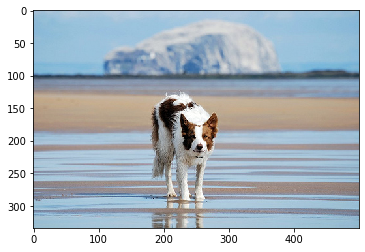

In [0]:
final_model_file = 'transfer.model.ep001.acc0.3713.h5'
img_file = root_path+'demo0.jpg'

caption = generate_example(cnn_model, final_model_file, img_file, tokenizer)
caption = ' '.join(caption)
show_img(img_file)
print(caption)

a man in a yellow helmet is riding a bike on a dirt bike


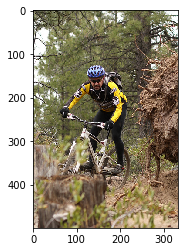

In [0]:
img_file = root_path+'demo2.jpg'

caption = generate_example(cnn_model, final_model_file, img_file, tokenizer)
caption = ' '.join(caption)
show_img(img_file)
print(caption)

two dogs are playing with a red ball


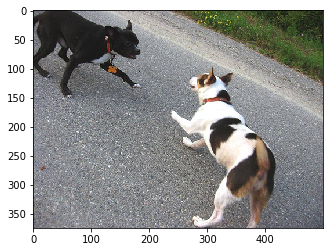

In [0]:
img_file = root_path+'demo3.jpg'

caption = generate_example(cnn_model, final_model_file, img_file, tokenizer)
caption = ' '.join(caption)
show_img(img_file)
print(caption)